# MNIST Odd-Even classification with TensorFlow (CNN)

## Data loading

Let's load the dataset using the Keras API implementation included in TensorFlow.

As we only want to classify the images between **odd** and **even** numbers, we will map labels to *1* if odd or *0* if even.

In [0]:
import tensorflow as tf
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Keep original test numbers for displaying misslcasificationsx
y_numbers = y_test

# Set Even or Odd labels for each sample
y_train = np.array(list(map(lambda x: x%2, y_train)), dtype=np.float32)
y_test = np.array(list(map(lambda x: x%2, y_test)), dtype=np.float32)

# Normalize images dividing by max pixel value (255)
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# Reshape to TF API (#img, rows, cols, channels)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

## CNN Model

### Neural Network architecture

We will use the classical architecture for a CNN (Convolution + Pooling > Convolution + Pooling > Flatten > Dense > Dense)

Instead of the common Convolution > ReLU > Pooling, we can apply the ReLU after Pooling step beacuse ReLU(MaxPooling(x)) == MaxPooling(ReLU(x)) and it will be more efficient, as the tensor size will be 75% smaller.

In [0]:
class CNNClassifier:
    def __init__(self, train_data=None):        
        self.train_data = train_data

        self.assemble_graph()

        self._open_session()
        
        self._draw_graph_tensorboard()

        if train_data:
            self.train()     

   
    def assemble_graph(self, learning_rate = 0.02):
        #### Placeholders/Variables/Constants
        
        self.X = tf.placeholder(name='X', dtype=tf.float32, shape=(None, 28, 28, 1))
        self.Y = tf.placeholder(name='Y', dtype=tf.float32, shape=(None,))
        self.L = tf.reshape(self.Y, shape=(-1, 1))
        
        #### Layers
        
        # 1st Convolutional Layer 3x5x5 Kernel + MaxPooling 2x2 + ReLu
        conv1 = tf.layers.conv2d(self.X, filters=3, kernel_size=(5, 5), padding='same')
        pool1 = tf.layers.max_pooling2d(conv1, pool_size=(2, 2), strides=2)
        relu1 = tf.nn.relu(pool1)
        
        # 2nd Convolutional Layer 3x5x5 Kernel + MaxPooling 2x2 + ReLu
        conv2 = tf.layers.conv2d(relu1, filters=3, kernel_size=(5, 5), padding='same')
        pool2 = tf.layers.max_pooling2d(conv2, pool_size=(2, 2), strides=2)
        relu2 = tf.nn.relu(pool2)
        
        # Flatten data into (-1, 7*7*3 tensor)
        flatten = tf.reshape(relu2, shape=(-1, 7*7*3))
        
        # Dense Layer 1 with 4 neurons
        dense1 = tf.layers.dense(flatten, units=4, activation=tf.nn.relu)
        
        # Dense Layer 2 with 1 neurons (our final output)
        output_layer = tf.layers.dense(dense1, units=1, activation=None)
        
        #### Optimizer, Loss, Predictions and Accuracy
        
        # Cross-Entropy as loss function
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.L, logits=output_layer)
        self.cost = tf.reduce_mean(cross_entropy)
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(self.cost)
        
        # Apply sigmoid and round to get the predicted class
        predicted = tf.nn.sigmoid(output_layer)
        self.predicted_class = tf.round(predicted)
        correct_pred = tf.equal(self.predicted_class, self.L)
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

 
    def train(self, epochs=10, minibatch_size=256):
        for epoch in range(1, epochs + 1):
            for batch_idx, (features, labels) in enumerate(self._create_minibatches(minibatch_size)):
                d = { self.X: features, self.Y: labels }
                loss, _, acc = self.sess.run([self.cost, self.optimizer, self.accuracy], feed_dict=d)
                
                if (batch_idx + 1) % 50 == 0:
                    n_treated = batch_idx * len(features)
                    p_treated = 100.0 * batch_idx * len(features) / 60000
                    msg = 'Epoch: {:>2} [{:>5}/{:>5} ({:2.0f}%)]\tLoss: {:2.6f}\tAccuracy: {:5.2f}%'
                    print(msg.format(epoch, n_treated, 60000, p_treated, loss, acc * 100))
            

    def predict(self, data):
        d = { self.X: data }
        return self.sess.run(self.predicted_class, feed_dict=d)

        
    def _create_minibatches(self, minibatch_size):
        pos = 0

        data, labels = self.train_data
        n_samples = len(labels)

        batches = []
        while pos + minibatch_size < n_samples:
            batches.append((data[pos:pos+minibatch_size,:], labels[pos:pos+minibatch_size]))
            pos += minibatch_size

        if pos < n_samples:
            batches.append((data[pos:n_samples,:], labels[pos:n_samples]))

        return batches

    
    def _open_session(self):
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
    
    
    def _draw_graph_tensorboard(self):
        writer = tf.summary.FileWriter('./tmp', self.sess.graph)
        writer.close()

In [3]:
from sklearn.metrics import accuracy_score, f1_score

svm = CNNClassifier((x_train, y_train))
predictions = svm.predict(x_test)
print('\nTesting score accuracy: {}'.format(accuracy_score(y_test, predictions)))
print('\nTesting score F1: {}'.format(f1_score(y_test, predictions)))

Epoch:  1 [12544/60000 (21%)]	Loss: 0.653937	Accuracy: 58.20%
Epoch:  1 [25344/60000 (42%)]	Loss: 0.614359	Accuracy: 69.53%
Epoch:  1 [38144/60000 (64%)]	Loss: 0.571658	Accuracy: 79.30%
Epoch:  1 [50944/60000 (85%)]	Loss: 0.521685	Accuracy: 79.30%
Epoch:  2 [12544/60000 (21%)]	Loss: 0.475745	Accuracy: 80.86%
Epoch:  2 [25344/60000 (42%)]	Loss: 0.442989	Accuracy: 82.42%
Epoch:  2 [38144/60000 (64%)]	Loss: 0.440048	Accuracy: 87.50%
Epoch:  2 [50944/60000 (85%)]	Loss: 0.380523	Accuracy: 89.84%
Epoch:  3 [12544/60000 (21%)]	Loss: 0.383006	Accuracy: 84.38%
Epoch:  3 [25344/60000 (42%)]	Loss: 0.338758	Accuracy: 87.11%
Epoch:  3 [38144/60000 (64%)]	Loss: 0.386207	Accuracy: 86.72%
Epoch:  3 [50944/60000 (85%)]	Loss: 0.281258	Accuracy: 93.36%
Epoch:  4 [12544/60000 (21%)]	Loss: 0.308543	Accuracy: 89.45%
Epoch:  4 [25344/60000 (42%)]	Loss: 0.256774	Accuracy: 91.41%
Epoch:  4 [38144/60000 (64%)]	Loss: 0.331257	Accuracy: 87.50%
Epoch:  4 [50944/60000 (85%)]	Loss: 0.215480	Accuracy: 96.09%
Epoch:  

## Missclassifications

In [0]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

def plot_missclasifications(preds):
    count = 0
    plt.figure(figsize=(20, 10))
    for i, pred in enumerate(preds):
        if pred != y_test[i]:
            msg = '{} ({})'
            msg = msg.format('Odd' if preds[i] else 'Even', str(y_numbers[i]))
        
            plt.subplot(3, 10, count + 1)
            plt.title(msg)
            plt.axis('off')
            plt.imshow(x_test[i].reshape(28, 28), cmap=cm.binary)
            count += 1
            if count == 30:
                break

Some missclassification examples:

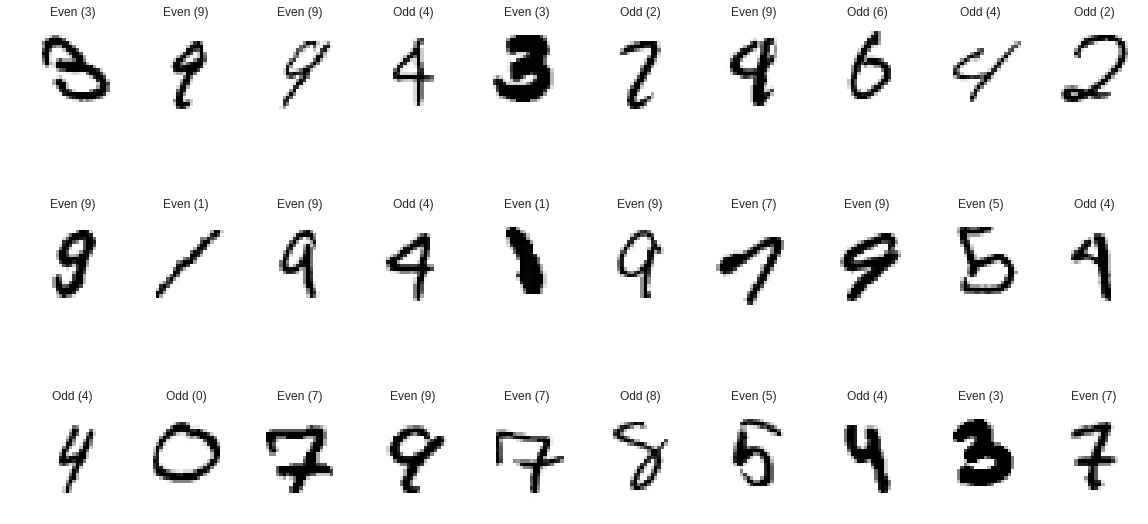

In [5]:
plot_missclasifications(predictions)

## TF Graph Visualization

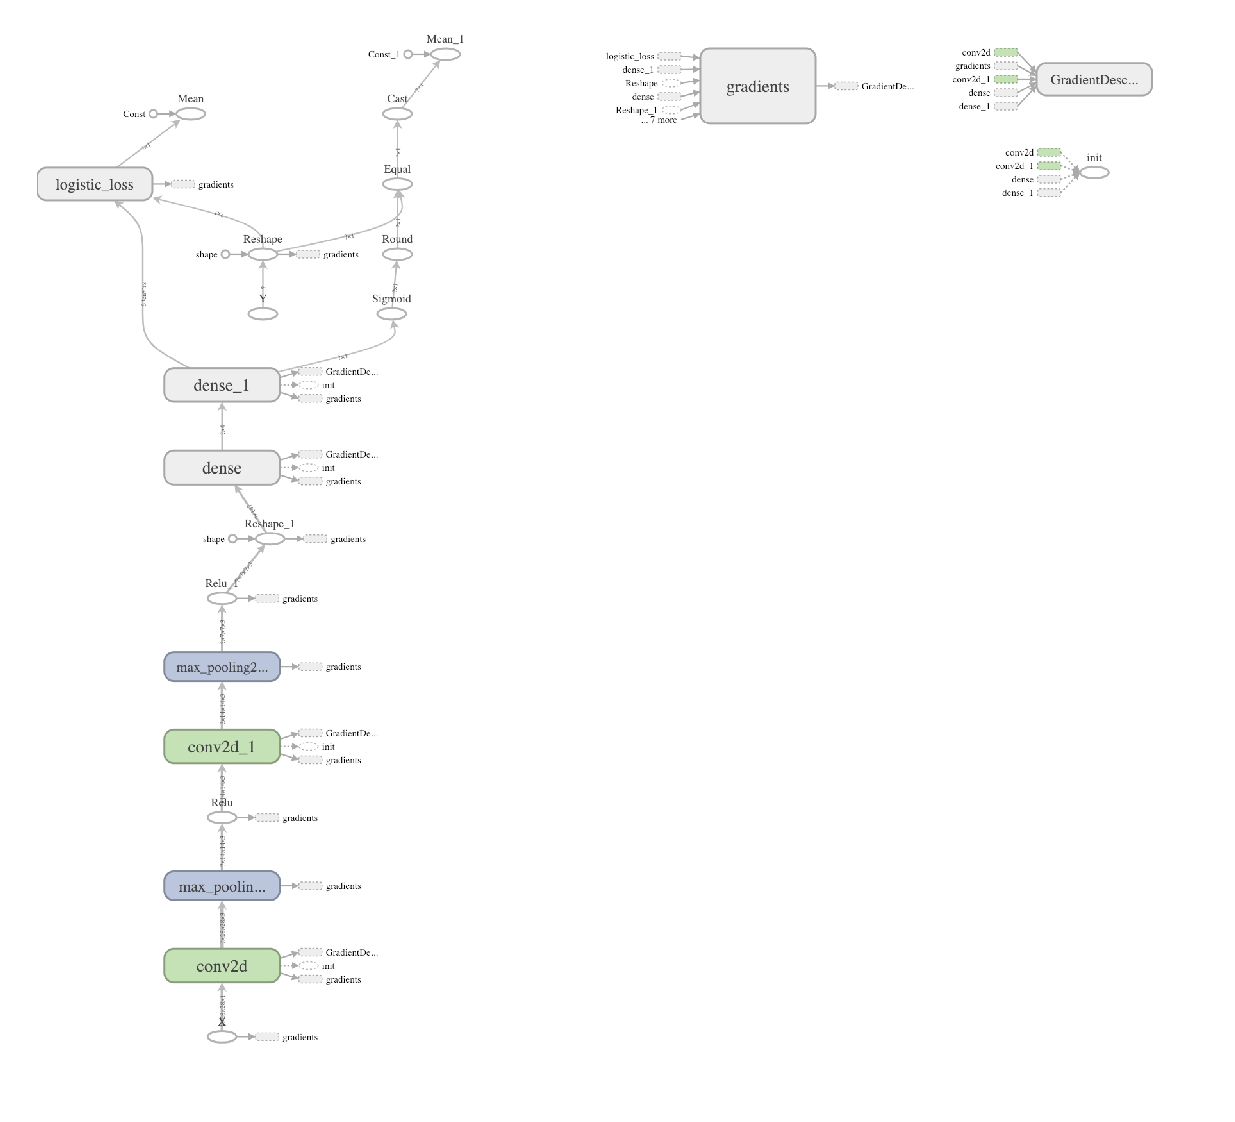

In [6]:
import matplotlib.image as mpimg

plt.figure(figsize=(30, 20))

img = mpimg.imread('tf_graph_cnn.png')
imgplot = plt.imshow(img)

plt.axis('off')
plt.show()

## Conclusions

**Q:** How many parameters does this model have comparing to SVM classifier?

**A:** *CNN* model is much more complex than the *SVM*, as involves much more parameters (both *trainable* and *hyperparameters*). We can observe the different parameters in the following table:


|   |  Trainable | Hyperparameters |
|---|---|---|
| SVM | - A<br/>- B | - A<br/>- B |
| CNN | - A<br/>- B | - A<br/>- B |

**Q:** Why performance of these two models is so different?

**A:** Referring to the results, the *CNN* outperforms our *SVM* results as it contains convolutional layers which are (almost) specifically designed for image processing, allowing to extract much mode trascendental features for the model training. Furthermore, we are using a vanilla *SVM* (*linear* kernel) and probably the data is not perfectly linear separable, so we could get a more accurated model by applying the "kernel trick" with a *RBF* or *Polynomial* kernel.